## 0. Import Libraries/Modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torch.utils.data import random_split

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')  # access google drive for saving model later

Mounted at /content/gdrive


In [3]:
! mkdir /content/gdrive/MyDrive/PIC16B/

mkdir: cannot create directory ‘/content/gdrive/MyDrive/PIC16B/’: File exists


In [4]:
PATH = "/content/gdrive/MyDrive/PIC16B/"

In [5]:
!pip install einops
!pip3 install --upgrade gdown --quiet
!gdown 1tHHD_wkOREgBSYpC0DqPeKIktx9G3P5X

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.6 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1tHHD_wkOREgBSYpC0DqPeKIktx9G3P5X
To: /content/data.tar.gz
100% 62.7M/62.7M [00:01<00:00, 33.9MB/s]


In [6]:
import tarfile
from tqdm import tqdm

data_path = './'
os.makedirs(os.path.join(data_path, 'Project', 'data'), exist_ok=True)
root_dir = os.path.join(data_path, 'Project')


tar = tarfile.open("data.tar.gz", "r:gz")
total_size = sum(f.size for f in tar.getmembers())
with tqdm(total=total_size, unit="B", unit_scale=True, desc="Extracting tar.gz file") as pbar:
    for member in tar.getmembers():
        tar.extract(member, os.path.join(root_dir, 'data'))
        pbar.update(member.size)

# Close the tar.gz file
tar.close()

Extracting tar.gz file: 100%|██████████| 69.6M/69.6M [00:04<00:00, 14.7MB/s]


## 1. Data Exploration
### 1-1. Sample Images

In [7]:
root_dir = os.path.join(root_dir, 'data', 'images')
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

These are the facial expressions we're trying to detect

In [8]:
target_var = os.listdir(train_dir)
target_var

['neutral', 'fear', 'disgust', 'angry', 'surprise', 'sad', 'happy']

### Define Data Transform

In [9]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    
    # Normalize image using ImageNet statistics
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

### Train, Validation Split

In [29]:
trainset = ImageFolder(train_dir, transform=data_transform)
testset = ImageFolder(test_dir, transform = data_transform)
dataset = torch.utils.data.ConcatDataset([trainset, testset])

test_size = int(len(dataset)*0.2)
val_size = int(len(dataset)*0.2)
train_size = len(dataset) - val_size - test_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(21533, 7177, 7177)

### Define the Train Method

In [11]:
def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    """
    Train the MLP classifier on the training set and evaluate it on the validation set every opch
    
    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    
    # Place model on device
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        
        # Use tqdm to displace a progress bar during training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero out gradients
                optimizer.zero_grad()
                
                # Compute the logits and loss
                logits = model(inputs)
                loss = criterion(logits, labels)
                
                # Backpropagate the loss
                loss.backward()
                
                # Update the weights
                optimizer.step()
                
                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())
                
        # Evaluate the model on the validation set
        total_loss_train, avg_loss_train, accuracy_train, total_loss, avg_loss, accuracy = \
                                  evaluate(model, train_loader, val_loader, criterion, device)
        print(f'Training set: Total loss = {total_loss_train:.4f}, Average loss = {avg_loss_train:.4f}, Accuracy = {accuracy_train:.4f}')
        print(f'Validation set: Total loss = {total_loss:.4f}, Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')
        
def evaluate(model, train_loader, test_loader, criterion, device):
    """
    Evaluate the MLP classifier on the test set.
    
    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.
        
    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0
        
        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)
        
            
    # Compute the average validation loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples


    # trainset accuracy
    with torch.no_grad():
        total_loss_train = 0.0
        num_correct = 0
        num_samples = 0
        
        for inputs, labels in train_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss_train += loss.item()
            
            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)

    # Compute the average training loss and accuracy
    avg_loss_train = total_loss / len(test_loader)
    accuracy_train = num_correct / num_samples
    
    return total_loss_train, avg_loss_train, accuracy_train, total_loss, avg_loss, accuracy

In [12]:
# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
    print(f'Using device: {device}, Good to go!')
else:
    print('GPU not available')

Using device: cuda, Good to go!


In [13]:
!nvidia-smi

Fri Mar 17 07:54:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    52W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Build the ResNet

#### Fully finetune with same learning rate

In [14]:
# List of image transformation
image_blurrer = transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.001,0.2))
image_rotate = transforms.RandomRotation((-20,20))
image_hflip = transforms.RandomHorizontalFlip(p=0.4)
image_vflip = transforms.RandomVerticalFlip(p=0.4)
image_randomP = transforms.RandomPerspective(distortion_scale=0.1, p=0.4)

In [15]:
class Resnet(nn.Module):
    def __init__(self, mode='finetune', augmented=False, pretrained=True):
        super().__init__()
        """
        use the resnet18 model from torchvision models. Remember to set pretrained as true
        
        mode has two options:
        1) linear: For this mode, we want to freeze resnet18 feautres, then train a linear
                    classifier which takes the features before FC (again we do not want the resnet18 FC).
                    And then write our own FC layer: which takes in the features and 
                    output scores of size 7 (since we have 7 categories)
        2) finetune: Same as 1) linear, except that we do not need to freeze the features and
                    can finetune on the pretrained resnet model.
        """
    
            
        self.augmented = augmented
        self.resnet = models.resnet50(pretrained=True)

        if mode == 'linear':
            for name, param in self.resnet.named_parameters():
                if param.requires_grad and 'fc' not in name:
                    param.requires_grad = False
            
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, 7)

        elif mode == 'finetune':
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, 7)

    def forward(self, x):
        if self.augmented:
            x = image_hflip(x)
            x = image_rotate(x)
            x = image_randomP(x)
        
        x = self.resnet(x)
        return x

    def to(self, device):
        return self.resnet.to(device=device)


In [16]:
'''
Setting lr to 0.01 for the last fc lyaer.
Setting lr to 0 for the resnet.layer1 and resnet.layer2 layers.
Setting lr to 0.001 for the rest layers.
'''

resnet_finetune101 = Resnet(mode='finetune', augmented = True, pretrained=True)

last_params, lower_params, rest_params = [], [], []

for name, param in resnet_finetune101.named_parameters():
    if 'fc' in name:
        last_params.append(param)
    elif 'layer1' in name or 'layer2' in name:
        lower_params.append(param)
    else:
        rest_params.append(param)

optimizer = torch.optim.SGD(
    [
        {"params": last_params, "lr": 0.01, "momentum": 0.9},
        {"params": lower_params, "lr": 0, "momentum": 0.9},
        {"params": rest_params, "lr": 0.001, "momentum": 0.9}
    ]
)

criterion = nn.CrossEntropyLoss()

# Define the batch size and number of workers
batch_size = 64
num_workers = 2
# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

# Train the model
model_name = "resnet_finetune_newset2.pt"
try:
  resnet_finetune101.load_state_dict(torch.load(PATH + model_name))
  # continue training for more epochs:
  # train(resnet_finetune3, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)
except:
  train(resnet_finetune101, train_loader, val_loader, optimizer, criterion, device, num_epochs=10)

torch.save(resnet_finetune101.state_dict(), PATH + model_name)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1/10: 100%|██████████| 359/359 [00:28<00:00, 12.73it/s, loss=0.453]


Training set: Total loss = 80.1376, Average loss = 0.6227, Accuracy = 0.9367
Validation set: Total loss = 56.6619, Average loss = 0.6227, Accuracy = 0.8168


Epoch 2/10: 100%|██████████| 359/359 [00:18<00:00, 19.03it/s, loss=0.554]


Training set: Total loss = 21.1422, Average loss = 0.7148, Accuracy = 0.9850
Validation set: Total loss = 65.0425, Average loss = 0.7148, Accuracy = 0.8232


Epoch 3/10: 100%|██████████| 359/359 [00:18<00:00, 19.08it/s, loss=0.0756]


Training set: Total loss = 25.3189, Average loss = 0.8615, Accuracy = 0.9780
Validation set: Total loss = 78.3923, Average loss = 0.8615, Accuracy = 0.8073


Epoch 4/10: 100%|██████████| 359/359 [00:18<00:00, 19.13it/s, loss=0.0741]


Training set: Total loss = 4.4219, Average loss = 0.8391, Accuracy = 0.9973
Validation set: Total loss = 76.3620, Average loss = 0.8391, Accuracy = 0.8380


Epoch 5/10: 100%|██████████| 359/359 [00:18<00:00, 19.27it/s, loss=0.235]


Training set: Total loss = 2.9732, Average loss = 0.9153, Accuracy = 0.9978
Validation set: Total loss = 83.2956, Average loss = 0.9153, Accuracy = 0.8380


Epoch 6/10: 100%|██████████| 359/359 [00:18<00:00, 19.32it/s, loss=0.0129]


Training set: Total loss = 2.6447, Average loss = 0.9190, Accuracy = 0.9979
Validation set: Total loss = 83.6272, Average loss = 0.9190, Accuracy = 0.8333


Epoch 7/10: 100%|██████████| 359/359 [00:18<00:00, 19.12it/s, loss=0.00215]


Training set: Total loss = 1.3618, Average loss = 0.9431, Accuracy = 0.9983
Validation set: Total loss = 85.8227, Average loss = 0.9431, Accuracy = 0.8380


Epoch 8/10: 100%|██████████| 359/359 [00:18<00:00, 19.17it/s, loss=0.0165]


Training set: Total loss = 1.2903, Average loss = 0.9648, Accuracy = 0.9984
Validation set: Total loss = 87.7989, Average loss = 0.9648, Accuracy = 0.8409


Epoch 9/10: 100%|██████████| 359/359 [00:18<00:00, 19.19it/s, loss=0.000788]


Training set: Total loss = 1.3235, Average loss = 0.9902, Accuracy = 0.9983
Validation set: Total loss = 90.1080, Average loss = 0.9902, Accuracy = 0.8364


Epoch 10/10: 100%|██████████| 359/359 [00:18<00:00, 19.09it/s, loss=0.00238]


Training set: Total loss = 1.2550, Average loss = 0.9839, Accuracy = 0.9983
Validation set: Total loss = 89.5368, Average loss = 0.9839, Accuracy = 0.8400


Epoch 10/10: 100%|██████████| 359/359 [00:18<00:00, 19.09it/s, loss=0.00238]

Training set: Total loss = 1.2550, Average loss = 0.9839, Accuracy = 0.9983

Validation set: Total loss = 89.5368, Average loss = 0.9839, Accuracy = 0.8400

In [17]:
torch.save(resnet_finetune101.state_dict(), PATH + model_name)

In [18]:
def test_evaluate(model, test_loader, criterion, device):
    model.eval().cuda()

    labels = []
    
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs[0].to(device)
            logits = model(inputs)
            _, predictions = torch.max(logits, dim=1)

            for prediction in predictions:
                labels += [prediction.item()]

    return labels

In [19]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

In [20]:
resnet_finetune101 = Resnet(mode='finetune', augmented = False, pretrained=True)
resnet_finetune101.load_state_dict(torch.load(PATH + model_name))
pred_labels = test_evaluate(resnet_finetune101, test_loader, nn.CrossEntropyLoss(), device)

In [21]:
count = 0
for i in range(len(pred_labels)):
    if pred_labels[i] == test_dataset[i][1]:
        count += 1

print(count / len(pred_labels))

0.8563466629510937


# Evaluate sample images and visualize the predicted fraction of each facial expression:

In [22]:
def get_sample_inputs(loader, seed=0):
  """
    Get the input and labels for each of the seven facial expressions
    seed: changes the set of images. < 64
  """
  true_labels = []
  all_inputs = []
  cnt = 0
  for inputs, labels in loader:
    labels = labels.numpy()
    if labels[seed] not in true_labels:
        all_inputs.append(inputs[seed])
        true_labels.append(labels[seed])
        if len(true_labels) == 7:
          return all_inputs, true_labels

In [23]:
def eval_sample_inputs(model, loader, device, seed=0):
  """
    Evaluate the inputs, relu and normalize output, return the fraction of each facial expression
  """
  pred_fractions = []
  pred_labels = []
  inputs, true_labels = get_sample_inputs(loader, seed)
  model.eval()

  with torch.no_grad():
    for input in inputs:
      logit = model(torch.tensor(np.expand_dims(input,axis=0)).to(device)).detach().cpu().numpy()
      pred = np.argmax(logit)
      logit = np.maximum(logit, 0)    # relu
      pred_fractions.append(logit / np.sum(logit))   # normalize
      pred_labels.append(pred)
  return inputs, true_labels, pred_fractions, pred_labels

In [24]:
inputs, true_labels, pred_fractions, pred_labels = eval_sample_inputs(resnet_finetune101, test_loader, device, seed=0)

In [25]:
class2label = testset.class_to_idx
label2class = {v: k for k, v in class2label.items()}

In [26]:
def show_samples(inputs, true_labels, pred_fractions, pred_labels):
  """
    Show sample images of the 7 facial expressions,
    with true and predicted labels, and predicted fractions for each expression
  """
  # inverse transform back to normal images
  invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                  transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])
  plt.figure(figsize=(20,20))
  for i in range(7):
    plt.subplot(3,3,i+1)
    image = invTrans(inputs[i])

    # dimension (3, 128, 128) to (128, 128, 3)
    image = np.moveaxis(image.numpy(), 0, -1)
    plt.imshow(image)
    plt.title(f"True Label: {label2class[true_labels[i]]}")

    frac = pred_fractions[i][0]
    sorted_id = np.flip(np.argsort(frac))
    valid_id = frac[sorted_id]!=0   # excluding zero fractions
    sorted_id = sorted_id[valid_id] # id of sorted fractions, big to small

    # xlabel text
    xlab = f"Predicted Label: {label2class[pred_labels[i]]}\n\n"
    for id in sorted_id:
      xlab += list(class2label.keys())[id]
      xlab += ': '
      xlab += str(np.round(pred_fractions[i][0][id]*100,2))
      xlab += "%\n"
    plt.xlabel(xlab)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
  plt.show()

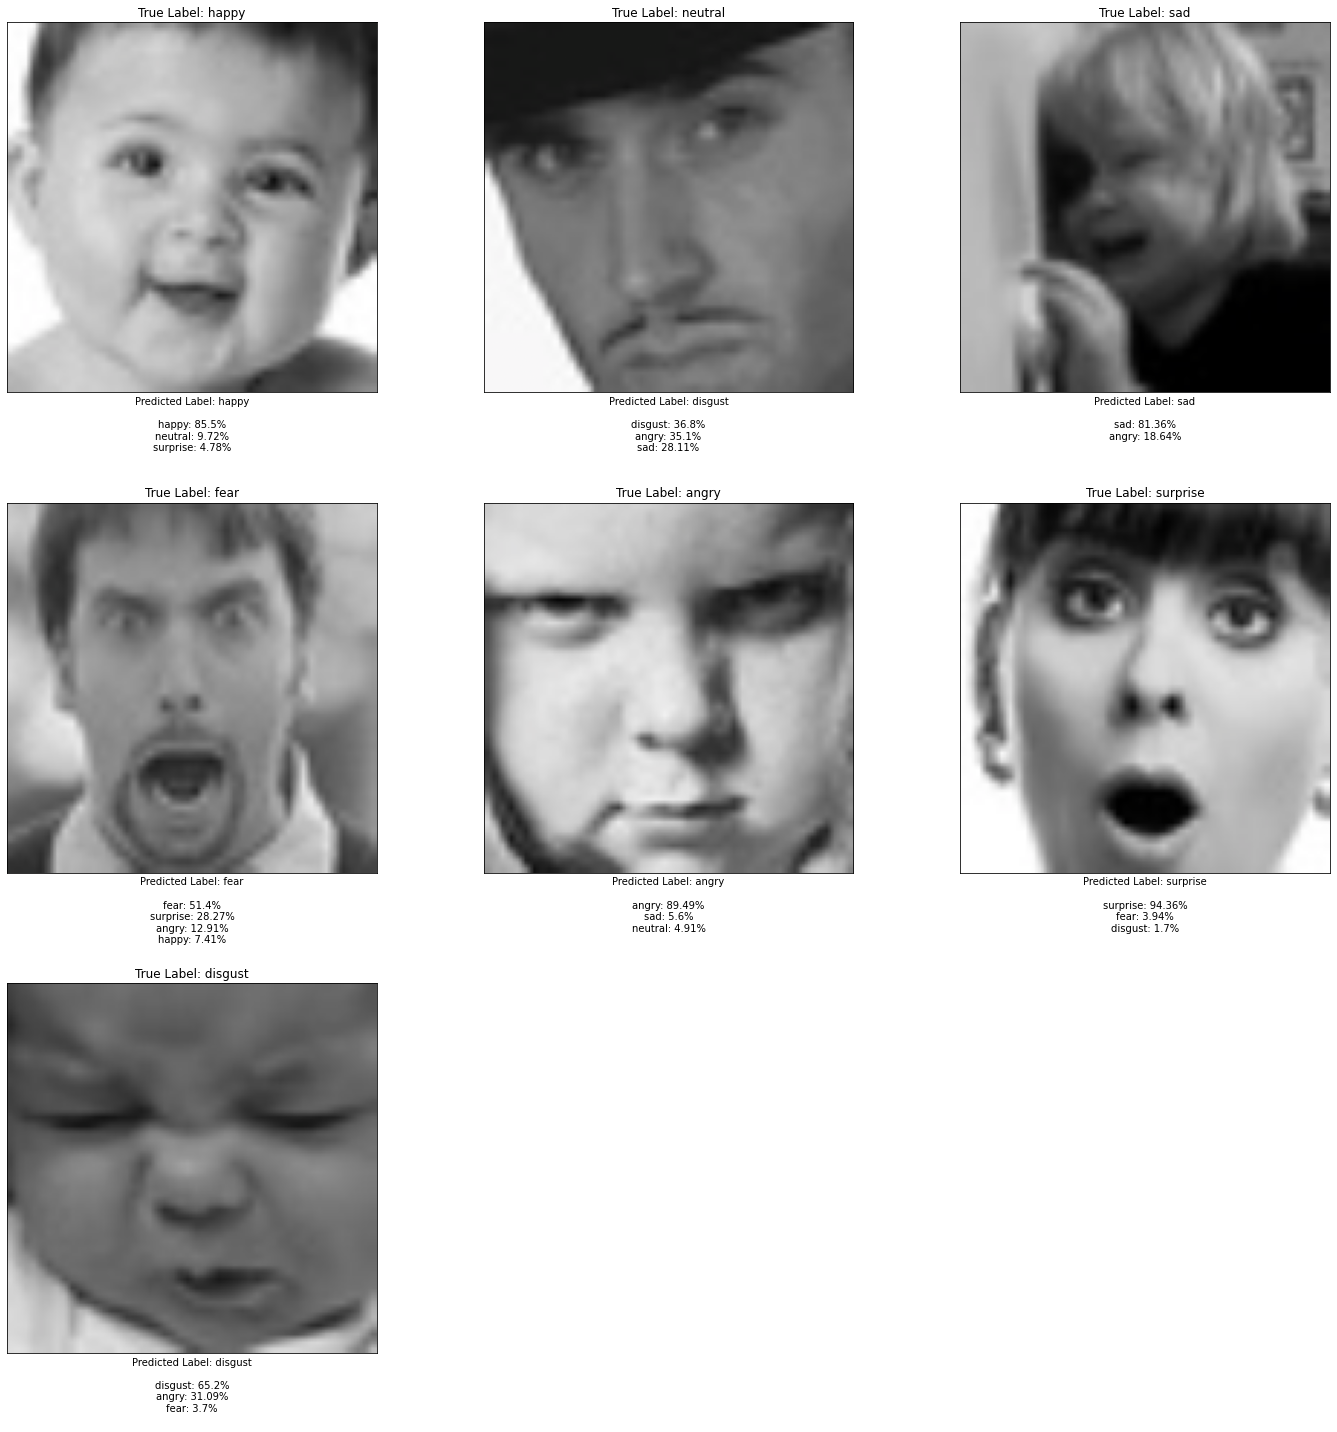

In [27]:
show_samples(inputs, true_labels, pred_fractions, pred_labels)

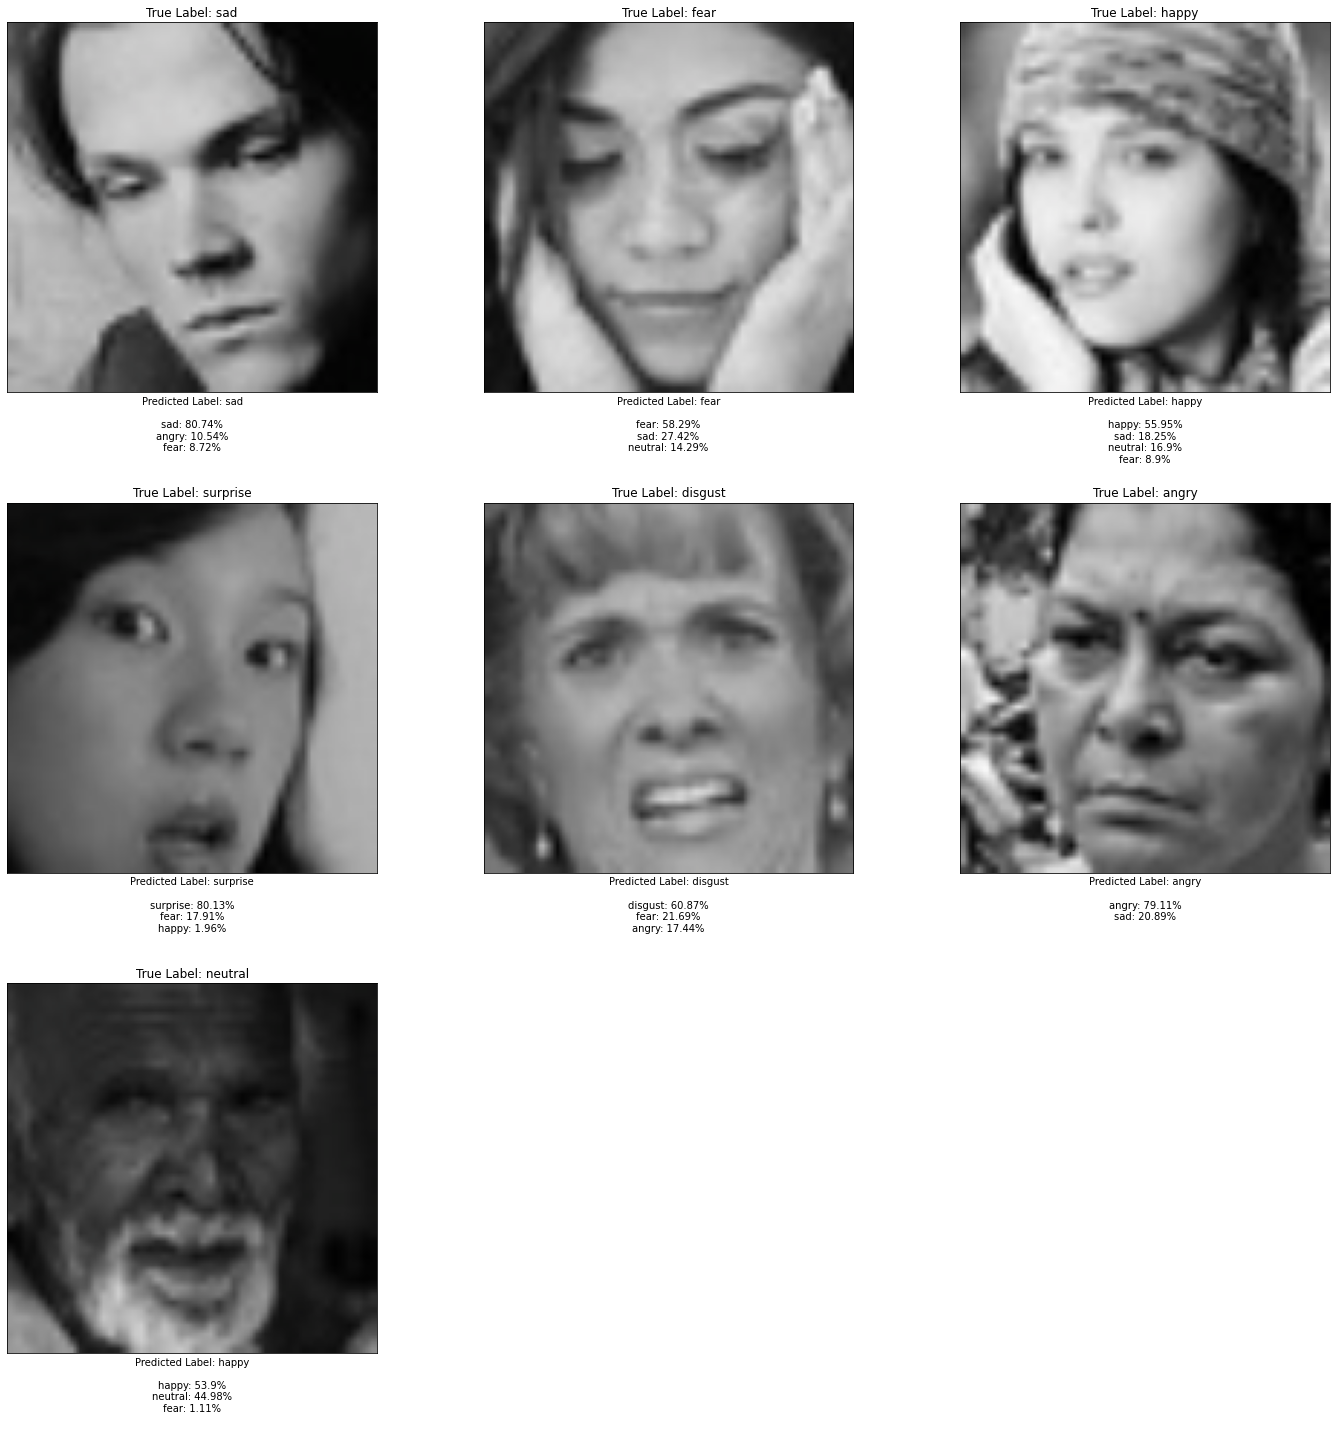

In [28]:
inputs, true_labels, pred_fractions, pred_labels = eval_sample_inputs(resnet_finetune101, test_loader, device, seed=10)
show_samples(inputs, true_labels, pred_fractions, pred_labels)